In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import matplotlib.ticker as mticker
import pandas as pd
from datetime import datetime
#from ta import *
from talib import RSI,BBANDS


In [37]:
def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height (if parameter
        `valley` is False) or peaks that are smaller than maximum peak height
         (if parameter `valley` is True).
    mpd : positive integer, optional (default = 1)
        detect_peakst peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=-1.2, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)

    Version history
    ---------------
    '1.0.5':
        The sign of `mph` is inverted if parameter `valley` is True
    
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
        if mph is not None:
            mph = -mph
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
            if mph is not None:
                mph = -mph
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind


def _plot(x, mph, mpd, threshold, edge, valley, ax, ind):
    """Plot results of the detect_peaks function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(8, 4))

        ax.plot(x, 'b', lw=1)
        if ind.size:
            label = 'valley' if valley else 'peak'
            label = label + 's' if ind.size > 1 else label
            ax.plot(ind, x[ind], '+', mfc=None, mec='r', mew=2, ms=8,
                    label='%d %s' % (ind.size, label))
            ax.legend(loc='best', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02*x.size, x.size*1.02-1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax.nwset_xlabel('Data #', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=14)
        mode = 'Valley detection' if valley else 'Peak detection'
        ax.set_title("%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"
                     % (mode, str(mph), mpd, str(threshold), edge))
        # plt.grid()
        plt.show()

Importing BTCUSDT data from csv

In [38]:
#data_btc1h=pd.read_csv("exchange_data/Binance_BTCUSDT_1h.csv",skiprows=2,index_col=0,names=['datetime','open','high','low','close','volume'])
data_btc1h=pd.read_csv("../exchange_data/Binance_BTCUSDT_1h.csv", parse_dates=True)



In [39]:
data_btc1h=data_btc1h.drop_duplicates(keep='first')

In [40]:
data_btc1h=data_btc1h[::-1]

In [41]:
#data_btc1h.index=pd.to_datetime(data_btc1h.index,unit='ms')

Calculating RSI data

In [42]:
#data_btc1h['rsi'] = rsi(data_btc1h['Close'], n=14)
data_btc1h['rsi']= RSI(data_btc1h['Close'], timeperiod=14)

In [43]:
data_btc1h.tail(20)


,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,rsi
19,2019-08-17 10-PM,BTCUSDT,10144.29,10239.71,10120.03,10236.13,732.52,7461657.75,48.566715
18,2019-08-17 11-PM,BTCUSDT,10236.13,10250.00,10178.57,10216.02,751.70,7675459.61,47.372911
17,2019-08-18 12-AM,BTCUSDT,10216.02,10278.88,10207.24,10227.21,514.08,5264732.94,48.136846
16,2019-08-18 01-AM,BTCUSDT,10227.21,10240.46,10151.42,10183.59,538.26,5485919.97,45.371977
15,2019-08-18 02-AM,BTCUSDT,10183.59,10207.42,10151.42,10168.76,469.52,4779065.59,44.437462
14,2019-08-18 03-AM,BTCUSDT,10168.76,10178.66,10102.56,10113.99,732.25,7418977.42,41.072816
13,2019-08-18 04-AM,BTCUSDT,10113.99,10142.30,10080.00,10132.54,768.62,7765182.89,42.656470
12,2019-08-18 05-AM,BTCUSDT,10132.54,10155.00,10105.01,10140.02,409.13,4144009.00,43.317974
11,2019-08-18 06-AM,BTCUSDT,10140.02,10201.14,10140.02,10166.87,588.32,5983041.58,45.737740
10,2019-08-18 07-AM,BTCUSDT,10166.87,10176.96,10115.97,10139.41,429.34,4353430.59,43.683793


In [44]:
#data_btc1h['Date'] = pd.to_datetime(data_btc1h.Date)
list(data_btc1h)

['Date',
 'Symbol',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume BTC',
 'Volume USDT',
 'rsi']

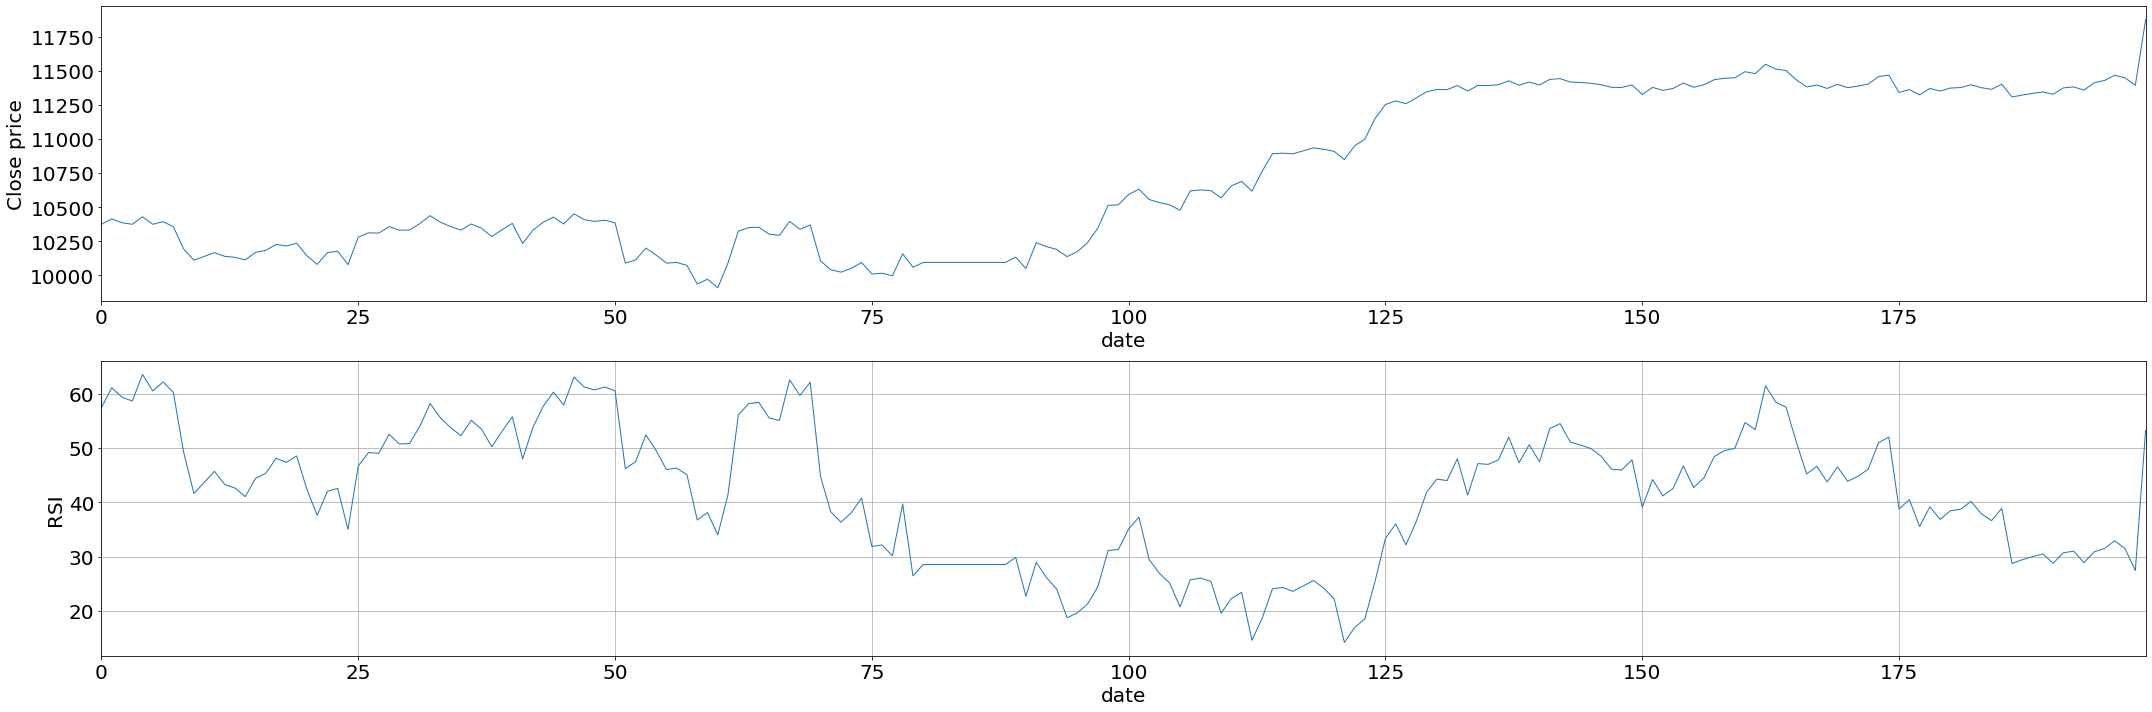

In [45]:
plt.figure()
plt.subplot(2, 1, 1)
data_btc1h['Close'].iloc[-200:].plot(figsize=(30,10), linewidth=1, fontsize=20)
plt.xlabel('date',fontsize=20)
plt.ylabel('Close price',fontsize=20)

plt.subplot(2, 1, 2)
data_btc1h['rsi'].iloc[-200:].plot(figsize=(30,10), linewidth=1, fontsize=20)
plt.xlabel('date',fontsize=20)
plt.ylabel('RSI',fontsize=20)

plt.grid(True)
plt.tight_layout()
plt.show()

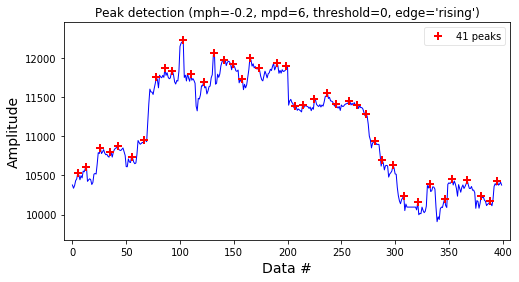

array([  5,  13,  26,  35,  42,  55,  67,  78,  86,  93, 103, 110, 122,
       132, 141, 149, 158, 165, 173, 190, 199, 207, 214, 225, 237, 245,
       257, 265, 273, 281, 288, 298, 308, 321, 332, 346, 353, 367, 380,
       388, 395])

In [46]:
detect_peaks(data_btc1h['Close'].iloc[-400:],mph=-0.2,mpd=6,show=True)

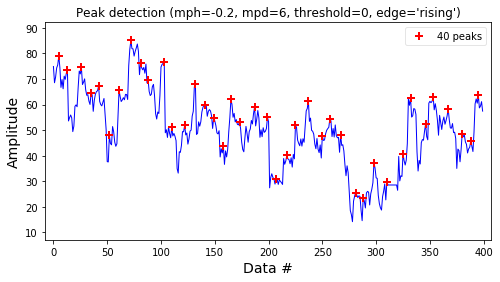

array([  5,  13,  26,  35,  42,  52,  61,  72,  81,  88, 103, 110, 122,
       132, 141, 149, 158, 165, 173, 187, 199, 207, 217, 225, 237, 250,
       257, 267, 281, 288, 298, 310, 325, 332, 346, 353, 367, 380, 388,
       395])

In [47]:
detect_peaks(data_btc1h['rsi'].iloc[-400:],mph=-0.20,mpd=6,show=True)

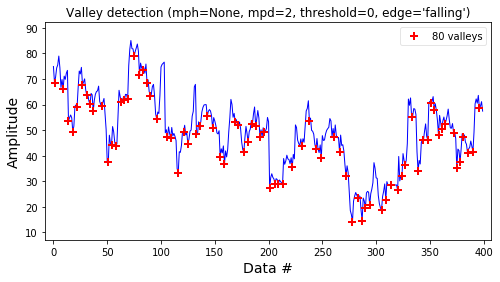

array([  1,   9,  14,  18,  22,  27,  31,  34,  37,  45,  51,  54,  58,
        63,  66,  69,  75,  80,  83,  87,  90,  96, 106, 109, 116, 121,
       125, 133, 136, 143, 148, 155, 159, 169, 172, 177, 181, 185, 188,
       192, 196, 201, 206, 209, 213, 222, 231, 238, 244, 249, 261, 266,
       272, 278, 283, 287, 290, 294, 305, 309, 314, 320, 324, 327, 333,
       339, 344, 348, 351, 354, 358, 361, 364, 372, 375, 378, 381, 385,
       390, 396])

In [48]:
detect_peaks(data_btc1h['rsi'].iloc[-400:],valley=True,edge='falling',mpd=2,show=True)


Divergence detection algorithm